# Dependencies and Data Loading

In [1]:
import os
import sys
import time
import numpy as np
import random
import pandas as pd
import scipy.io as sio
from collections import Counter
from itertools import product
from scipy.io import loadmat
import tensorflow as tf
from keras.utils import np_utils
from tensorflow.keras import optimizers,backend
from keras.models import Sequential
from keras.layers import Dropout, Activation, Dense, Flatten, Lambda, concatenate
from keras.layers.convolutional import Convolution1D,MaxPooling1D
from keras.callbacks import ModelCheckpoint
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# load training data 

# synthetic training data
filename = '/content/drive/My Drive/Manuscript_EJNMMI_2021/Github/Traindata_synthetic.mat'
input = loadmat(filename)
input_spectra_1 = input['spectra_syn_train']
labels_1 = input['pH_labels_syn_train']

# denoised kidney training data 
filename = '/content/drive/My Drive/Manuscript_EJNMMI_2021/Github/Traindata_kidney_aug.mat'
input = loadmat(filename)
input_spectra_2 = input['spectra_kidney_aug_train']
labels_2 = input['pH_labels_kidney_aug_train']

# replace n spectra of from the synthetic data depending on the size of the real data
n_2keep = len(input_spectra_1) - len(input_spectra_2)

# Combine training data
input_spectra = np.append(input_spectra_1[0:n_2keep], input_spectra_2 , axis=0)
labels = np.append(labels_1[0:n_2keep], labels_2,axis=0)

In [6]:
display(input_spectra.shape)
display(labels.shape)

(10000, 1024)

(10000, 3)

In [7]:
# load testdata - synthetic spectra
filename = '/content/drive/My Drive/Manuscript_EJNMMI_2021/Github/Testdata_synthetic.mat'
test_aug = loadmat(filename)
test_input_spectra_aug = test_aug['spectra_syn_test']
test_labels_aug = test_aug['pH_labels_syn_test']

# load testdata - kidney
filename = '/content/drive/My Drive/Manuscript_EJNMMI_2021/Github/Testdata_kidney.mat'
test = loadmat(filename)
test_input_spectra = test['spectra_kidney_test']
test_labels = test['pH_labels_kidney_test']

In [8]:
display(test_input_spectra_aug.shape)
display(test_labels_aug.shape)
display(test_input_spectra.shape)
display(test_labels.shape)

(20, 1024)

(20, 3)

(8, 1024)

(8, 3)

# Preprocessing

In [9]:
X_train, X_val, y_train, y_val = train_test_split(input_spectra, labels, test_size=0.15, random_state=13)

X_train = np.array(X_train).astype('float32')
X_train = X_train.reshape(X_train.shape + (1,))
X_val = np.array(X_val).astype('float32')
X_val = X_val.reshape(X_val.shape + (1,))

X_test = np.array(test_input_spectra).astype('float32')
X_test = X_test.reshape(X_test.shape + (1,))
X_test_aug = np.array(test_input_spectra_aug).astype('float32')
X_test_aug = X_test_aug.reshape(X_test_aug.shape + (1,))

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(test_labels)
y_test_aug = np.array(test_labels_aug)

print("Total of "+str(len(X_train))+" training samples.")
print("Total of "+str(len(X_val))+" validation samples.")

Total of 8500 training samples.
Total of 1500 validation samples.


Total of 8500 training samples.
Total of 1500 validation samples.


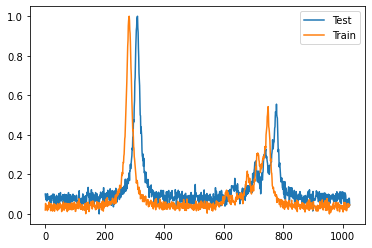

In [10]:
displayind = 2
print("Total of "+str(len(X_train))+" training samples.")
print("Total of "+str(len(X_val))+" validation samples.")
plt.plot(X_train[displayind],label='input')
plt.plot(X_val[displayind],label='ground truth')
plt.legend(['Test', 'Train'], loc='upper right')
plt.show()

# Model Architecture

In [11]:
def mapping_to_target_range( x, target_min=6.32, target_max=7.44) :
    x02 = backend.tanh(x) + 1 
    scale = ( target_max-target_min )/2.
    return  x02 * scale + target_min

In [12]:
# default random initialization for weights
backend.clear_session()

model = Sequential()
model.add(Dense(16, input_shape=(1024,1), activation='relu'))
model.add(MaxPooling1D())

model.add(Dense(16, activation='relu'))
model.add(MaxPooling1D())

model.add(Dense(32, activation='relu'))
model.add(MaxPooling1D())

model.add(Dense(32, activation='relu'))
model.add(MaxPooling1D())
model.add(Dropout(0.10))

model.add(Flatten())
model.add(Dense(3,activation=mapping_to_target_range))
nadam = optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss='mean_squared_error', optimizer=nadam)

print(model.summary())
print("MLP Model created.")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024, 16)          32        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 512, 16)          0         
 )                                                               
                                                                 
 dense_1 (Dense)             (None, 512, 16)           272       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 256, 16)          0         
 1D)                                                             
                                                                 
 dense_2 (Dense)             (None, 256, 32)           544       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 128, 32)          0

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/nadam.py:73: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


# Training

In [13]:
epochs = 400
batch_size = 200

best_model_file = '/content/drive/My Drive/weights/KidNeYronal_model_mlp-mix.h5'
start = time.time()

best_model = ModelCheckpoint(best_model_file, monitor='loss', verbose = 1, save_best_only=True, save_weights_only=False)
hist = model.fit(X_train,
                 y_train,
                 validation_data=(X_val, y_val),  
                 epochs=epochs,
                 batch_size=batch_size,
                 callbacks = [best_model],
                 shuffle = True,
                 verbose=1)

print("training time: ",time.time()-start)
print("done")

Epoch 1/400
42/43 [============================>.] - ETA: 0s - loss: 0.0230
Epoch 00001: loss improved from inf to 0.02280, saving model to /content/drive/My Drive/weights/KidNeYronal_model_mlp-mix.h5
43/43 [==============================] - 30s 592ms/step - loss: 0.0228 - val_loss: 0.0019
Epoch 2/400
43/43 [==============================] - ETA: 0s - loss: 0.0018
Epoch 00002: loss improved from 0.02280 to 0.00184, saving model to /content/drive/My Drive/weights/KidNeYronal_model_mlp-mix.h5
43/43 [==============================] - 1s 23ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 3/400
43/43 [==============================] - ETA: 0s - loss: 0.0017
Epoch 00003: loss improved from 0.00184 to 0.00174, saving model to /content/drive/My Drive/weights/KidNeYronal_model_mlp-mix.h5
43/43 [==============================] - 1s 22ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 4/400
43/43 [==============================] - ETA: 0s - loss: 0.0017
Epoch 00004: loss improved from 0.00174 to 0.00

(0.0, 0.01)

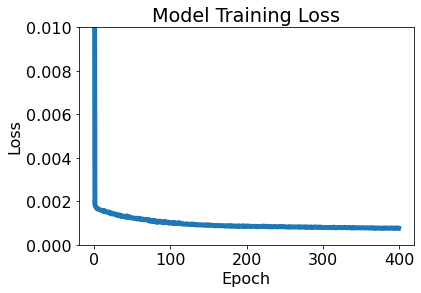

In [14]:
plt.rcParams.update({'font.size': 16})
plt.plot(hist.history['loss'], linewidth = 5)
plt.title('Model Training Loss')
plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.ylim(top=0.01,bottom=0) 

(0.0, 0.005)

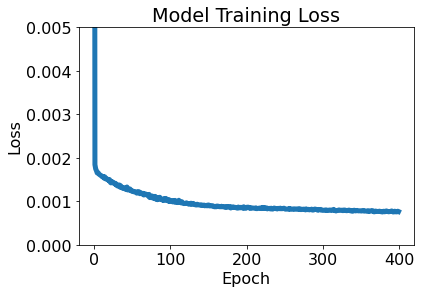

In [15]:
plt.plot(hist.history['loss'], linewidth = 5)
plt.title('Model Training Loss')
plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.ylim(top=0.005,bottom=0) 

(0.0, 0.01)

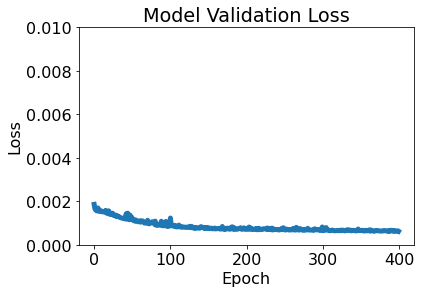

In [16]:
# 4
plt.plot(hist.history['val_loss'], linewidth = 5)
plt.title('Model Validation Loss')
plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.ylim(top=0.01,bottom=0) 

(0.0, 0.005)

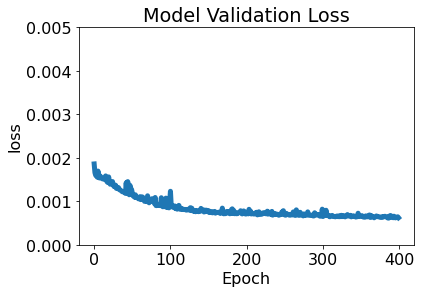

In [17]:
plt.plot(hist.history['val_loss'], linewidth = 5)
plt.title('Model Validation Loss')
plt.ylabel('loss'), plt.xlabel('Epoch')
plt.ylim(top=0.005,bottom=0) 

In [18]:
print(hist.history.keys())

dict_keys(['loss', 'val_loss'])


# Testing Model Accuracy

In [19]:
predict = model.predict(X_test)
dis_index = 0     #index for the test data

In [20]:
def plot_predict_gt(predict_aug,y_test_aug):
  predict_output = pd.DataFrame({'predict':predict_aug,'ground truth':y_test_aug})
  predict_output = pd.DataFrame.transpose(predict_output)
  print('test: ',dis_index+1)
  print(predict_output)
  plt.figure()
  plt.plot(X_test[dis_index,:] )
  plt.title('spect= %i' %(dis_index+1))
  plt.ylabel('Intensity')
  print('\n')

test:  1
                     0         1        2
predict       7.408769  7.117866  6.59433
ground truth  7.429000  7.146000  6.73900


test:  2
                    0         1         2
predict       7.37588  7.095028  6.473139
ground truth  7.36300  7.103000  6.414000


test:  3
                     0         1         2
predict       7.365271  7.089524  6.582434
ground truth  7.332000  7.118000  6.381000


test:  4
                     0         1       2
predict       7.403727  6.975792  6.4298
ground truth  7.395000  6.970000  6.3260


test:  5
                     0        1         2
predict       7.407209  7.16455  6.733026
ground truth  7.351000  7.16600  6.750000


test:  6
                     0         1       2
predict       7.419741  7.032852  6.4183
ground truth  7.396000  7.045000  6.5290


test:  7
                     0         1        2
predict       7.407248  7.177159  6.72427
ground truth  7.431000  7.150000  6.76800


test:  8
                     0         1   

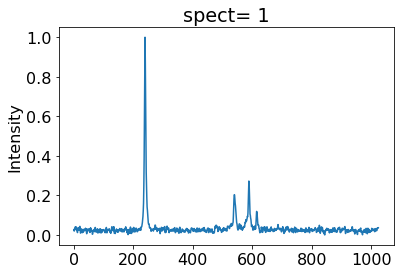

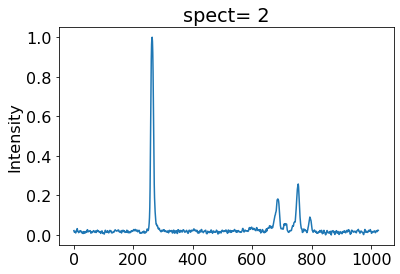

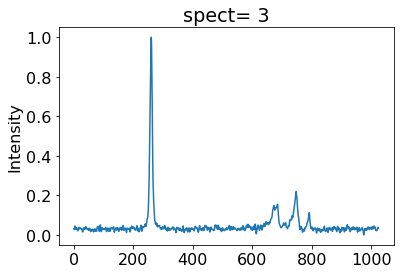

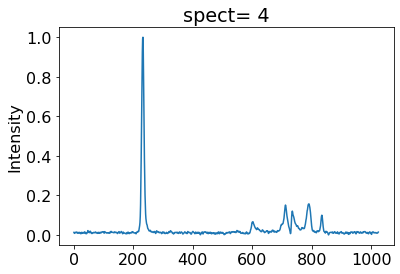

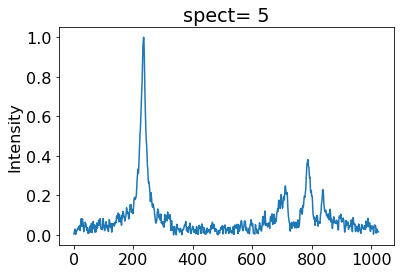

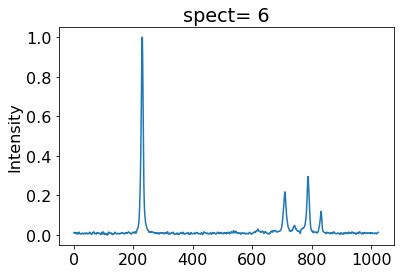

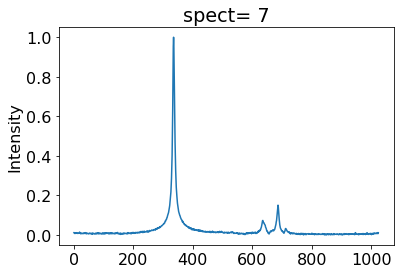

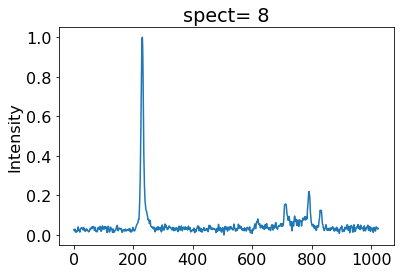

In [21]:
dis_index = 0
for idx in range(len(predict)):
  plot_predict_gt(predict[dis_index,:],y_test[dis_index,:])
  dis_index +=1

# Testing Model Accuracy - Synthetic data


In [22]:
predict_aug = model.predict(X_test_aug)

In [23]:
def print_predict_gt(predict_aug,y_test_aug):
  predict_output = pd.DataFrame({'predict':predict_aug,'ground truth':y_test_aug})
  predict_output = pd.DataFrame.transpose(predict_output)
  print('test: ',dis_index+1)
  print(predict_output)

In [24]:
dis_index = 0
for idx in range(len(predict_aug)):
  print_predict_gt(predict_aug[dis_index,:],y_test_aug[dis_index,:])
  dis_index +=1


test:  1
                     0         1         2
predict       7.382405  7.058107  6.493946
ground truth  7.366038  7.071987  6.522446
test:  2
                     0         1         2
predict       7.385534  7.075329  6.546074
ground truth  7.440000  7.006862  6.779162
test:  3
                     0         1         2
predict       7.383192  7.068569  6.507793
ground truth  7.367518  7.109335  6.486110
test:  4
                     0         1         2
predict       7.384328  7.056928  6.559126
ground truth  7.393396  7.006035  6.516890
test:  5
                     0         1         2
predict       7.396326  7.051642  6.471872
ground truth  7.405328  7.071277  6.422578
test:  6
                     0         1         2
predict       7.380906  7.059643  6.550314
ground truth  7.375795  7.023096  6.567435
test:  7
                     0         1         2
predict       7.387243  7.053322  6.475902
ground truth  7.400738  7.062025  6.364269
test:  8
                     0   